# Perception Block

In [1]:
import os
import importlib
import sys
import trajectories as traj
import numpy as np
from sklearn.cluster import DBSCAN


import hw

from pydrake.all import (
    AbstractValue,
    AddDefaultVisualization,
    AddMultibodyPlantSceneGraph,
    ConstantVectorSource,
    DiagramBuilder,
    LeafSystem,
    LoadModelDirectives,
    LoadModelDirectivesFromString,
    Parser,
    PiecewisePose,
    ProcessModelDirectives,
    RigidTransform,
    RotationMatrix,
    RollPitchYaw,
    Simulator,
    StartMeshcat,
    LeafSystem,
    ConstantVectorSource
)
from IPython.display import display, SVG
import pydot
import matplotlib.pyplot as plt
from pydrake.common import temp_directory
from pydrake.geometry import StartMeshcat
from pydrake.systems.analysis import Simulator
from pydrake.systems.controllers import JointStiffnessController
from pydrake.visualization import ModelVisualizer
from copy import deepcopy

from manipulation import running_as_notebook
from manipulation.station import LoadScenario, MakeHardwareStation,AddPointClouds
from manipulation.utils import ConfigureParser
import env_ingredient_add as env


def get_scene():
    if os.getcwd() == "/datasets/_deepnote_work/manipulation/project": 
        #scene = open("/work/manipulation/project/objects/environment_setup.yaml")
        scene = env.pizza_state_environment_set_up()
        xmls = [os.getcwd() + "/package.xml", "/work/manipulation/project/package.xml"]
    else:
        scene = env.pizza_state_environment_set_up()
        xmls = [os.getcwd() + "/package.xml"]

    return scene


In [2]:
# Start the visualizer. The cell will output an HTTP link after the execution.
# Click the link and a MeshCat tab should appear in your browser.
scenario = hw.LoadScenario(data=get_scene())
meshcat = hw.StartMeshcat()

INFO:drake:Meshcat listening for connections at https://92fbdad2-a4a9-4ef8-b493-c307060b34a1.deepnoteproject.com/7000/
Installing NginX server for MeshCat on Deepnote...


# Sim environment 

In [3]:
importlib.reload(hw)
diagram,sim = hw.init_diagram(meshcat,scenario)
hw.print_diagram(diagram)
#hw.run_simulation(meshcat,sim,20)



INFO:drake:PackageMap: Downloading https://github.com/RobotLocomotion/models/archive/47a987adcc9521bea2c300fee2c334bd5950d3eb.tar.gz
material [ 'mat1' ] not found in .mtl
material [ 'mat1' ] not found in .mtl


material [ 'mat1' ] not found in .mtl
material [ 'mat1' ] not found in .mtl

Diagram saved to diagram.png


## Perception - Plumbing 

In [4]:
class CameraSystem:
    def __init__(self, idx, meshcat, diagram, context):
        self.idx = idx

        # Read images
        depth_im_read = (
            diagram.GetOutputPort("camera_{}.depth_image".format(idx))
            .Eval(context)
            .data.squeeze()
        )
        self.depth_im = deepcopy(depth_im_read)
        self.depth_im[self.depth_im == np.inf] = 10.0
        self.rgb_im = (
            diagram.GetOutputPort("camera_{}.rgb_image".format(idx)).Eval(context).data
        )

        # Visualize
        point_cloud = diagram.GetOutputPort("table_camera_{}_ptcloud".format(idx)).Eval(
            context
        )
        #meshcat.SetObject(f"Camera {idx} point cloud", point_cloud)

        # Get info about the camera
        station = diagram.GetSubsystemByName("station")
        # Get other info about the camera
        cam = station.GetSubsystemByName("rgbd_sensor_table_camera_" + str(idx))
        cam_context = cam.GetMyMutableContextFromRoot(context)
        self.X_WC = cam.body_pose_in_world_output_port().Eval(cam_context)
        self.cam_info = cam.default_depth_render_camera().core().intrinsics()

    def project_depth_to_pC(self, depth_pixel):
        """
        project depth pixels to points in camera frame
        using pinhole camera model
        Input:
            depth_pixels: numpy array of (nx3) or (3,)
        Output:
            pC: 3D point in camera frame, numpy array of (nx3)
        """
        # switch u,v due to python convention
        v = depth_pixel[:, 0]
        u = depth_pixel[:, 1]
        Z = depth_pixel[:, 2]
        cx = self.cam_info.center_x()
        cy = self.cam_info.center_y()
        fx = self.cam_info.focal_x()
        fy = self.cam_info.focal_y()
        X = (u - cx) * Z / fx
        Y = (v - cy) * Z / fy
        pC = np.c_[X, Y, Z]
        return pC

environment_diagram, sim = hw.init_diagram(meshcat,scenario)
environment_context = environment_diagram.CreateDefaultContext()
# station_2=environment_diagram.GetSubsystemByName("station")
# station_context= environment_diagram.GetMutableSubsystemContext(station_2, environment_context)

cameras = []
cameras.append(CameraSystem(0, meshcat, environment_diagram, environment_context))

point_cloud = environment_diagram.GetOutputPort("table_camera_0_ptcloud").Eval(environment_context)


material [ 'mat1' ] not found in .mtl
material [ 'mat1' ] not found in .mtl


material [ 'mat1' ] not found in .mtl
material [ 'mat1' ] not found in .mtl



## Visualize 

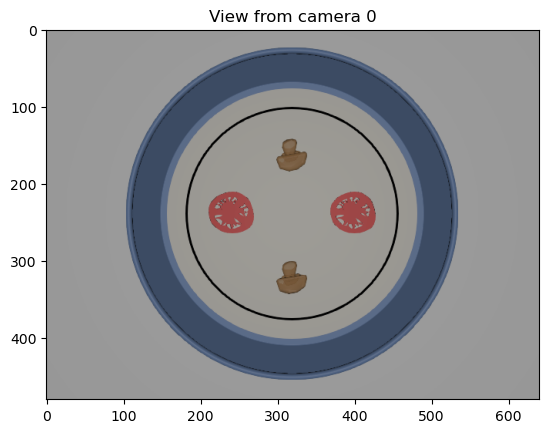

In [5]:
plt.imshow(cameras[0].rgb_im)
plt.title("View from camera 0")
plt.show()

# Filter Point Cloud by Color

Here we filter the point cloud by specific color so that we can isolate each type of ingredients. 

In [6]:
def filter_point_cloud_by_color(points, colors, target_color, color_threshold):
#Filters a point cloud by color and returns the filtered points and colors.

    target_color = np.array(target_color)
    color_difference = np.linalg.norm(colors - target_color, axis=1)
    indices = color_difference < color_threshold

    # Filter points and colors
    filtered_points = points[indices]
    filtered_colors = colors[indices]
    
    return filtered_points, filtered_colors

def visualize_point_cloud(points, colors):
    # 2D visualization of point cloud
    x = points[:, 0]
    y = points[:, 1]
    
    
    plt.figure(figsize=(10, 8))
    plt.scatter(x, y, c=colors, marker='o', s=5)  

    plt.title("Pizza WorkStation View")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.gca().set_aspect('equal', adjustable='box')

    plt.colorbar()  # Add color bar to see the RGB range
    plt.show()



# Clustering and fitting algorithms

We use this function to fit a circle to the pizza area, to calculate ingredient ratio. Dough is beige so that area is based on white RGB data 

This cannot use the convex hull code before as ingredients on the edge would disturbe the shape of the dough and not give an accurate area. forcing the circle fitting makes sure 

In [7]:

def fit_circle_np(points):
    x = points[:, 0]
    y = points[:, 1]
    
    # x^2 + y^2 = 2 * x_center * x + 2 * y_center * y + r^2
    # We rewrite it as a linear system Ax = b:

    A = np.vstack([2*x, 2*y, np.ones_like(x)]).T
    b = x**2 + y**2
    
    # Solve sytem Ax = b using least squares
    params, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    
    x_center = params[0]
    y_center = params[1]
    r_squared = params[2] + x_center**2 + y_center**2 
    radius = np.sqrt(r_squared)
    
    return x_center, y_center, radius

We use the functions below to first cluster using DBSCAN and then make a fitted polygon using convex hull. We then calculate the are of the polygon. 

In [13]:
#Area of each cluster of the RGB color added together 
def calculate_total_area(filtered_points, labels):
    total_area = 0
    # Iterate over clusters
    for label in np.unique(labels):
        #ignore noise
        if label == -1:  
            continue
        cluster = filtered_points[labels == label]
        if len(cluster) >= 3:  #we are using convex hull technique , that is only possible if there is a minimmum of 3 points
            hully = convex_hull(cluster)
            total_area += polygon_area(hully)#add individual areas to total area count
    
    return total_area


#DBSCAN for figuring out clusters of points
def get_clusters(filtered_points, eps=0.05, min_samples=10):
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(filtered_points)
    return labels


def convex_hull(points):
    #use Andrew's Monotone Chain Algorithm to find convex hull -> https://en.wikibooks.org/wiki/Algorithm_Implementation/Geometry/Convex_hull/Monotone_chain
    points = points[np.argsort(points[:, 0])]
    
    # Build the lower hull
    lower = []
    for p in points:
        while len(lower) >= 2 and np.cross(lower[-1] - lower[-2], p - lower[-1]) <= 0:
            lower.pop()
        lower.append(p)

    # Build the upper hull
    upper = []
    for p in reversed(points):
        while len(upper) >= 2 and np.cross(upper[-1] - upper[-2], p - upper[-1]) <= 0:
            upper.pop()
        upper.append(p)

    # Add the lower and upper hull
    return np.array(lower[:-1] + upper[:-1])

#Calculate area from convex hull
def polygon_area(hull_points):
    x = hull_points[:, 0]
    y = hull_points[:, 1]
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))


def visualize_clusters_with_hull(filtered_points,filtered_colors, labels):
    plt.figure(figsize=(10, 8))
    plt.scatter(filtered_points[:, 0], filtered_points[:, 1], c=filtered_colors, marker='o', s=5)
    
    # Plot the convex hulls for each cluster
    for label in np.unique(labels):
        if label == -1:  # Skip noise points
            continue
        
        cluster_points = filtered_points[labels == label]
        if len(cluster_points) >= 3:
            hull_points = convex_hull(cluster_points)
            hull_points = np.vstack([hull_points, hull_points[0]])  # Close the loop
            plt.plot(hull_points[:, 0], hull_points[:, 1], 'r-', lw=2)

    # Set title and labels
    plt.title("Top-Down View of Filtered Points with Convex Hulls for Each Cluster")
    plt.xlabel("X")
    plt.ylabel("Y")

    # Set aspect ratio to equal for correct representation
    plt.gca().set_aspect('equal', adjustable='box')

    # Show the plot
    plt.colorbar()  # Add color bar to show RGB range
    plt.show()

    return None


# Get Ingredient To Pizza Ratios

We are now making functions to get the ratios of ingredients to pizza.  The are of the pizza is always: 0.09285606596358834

In [11]:
#Calculate area ratio of ingredients

def calculate_tomato_to_pizza_ratio(points,colors, pizza_area, visualize_point=False, visualize_clusters=False):
    target_color = (1, 0, 0)
    filtered_points, filtered_colors = filter_point_cloud_by_color(points, colors, target_color, color_threshold=0.6)
    filtered_points_2d = filtered_points[:, :2]  
    labels = get_clusters(filtered_points_2d)
    area_tomatoes = calculate_total_area(filtered_points_2d, labels)
    ratio_tomatoes = area_tomatoes/area_of_pizza *100
    if visualize_point == True:
        visualize_point_cloud(filtered_points, filtered_colors)
    if visualize_clusters == True:
        visualize_clusters_with_hull(filtered_points_2d, filtered_colors, labels)

    return ratio_tomatoes

def calculate_mushroom_to_pizza_ratio(points,colors, pizza_area, visualize_point=False, visualize_clusters=False):
    target_color = (0.5, 0.4, 0.2)
    filtered_points, filtered_colors = filter_point_cloud_by_color(points, colors, target_color, color_threshold=0.1)
    filtered_points_2d = filtered_points[:, :2]  
    labels = get_clusters(filtered_points_2d)
    area_mushrooms = calculate_total_area(filtered_points_2d, labels)
    ratio_mushrooms = area_mushrooms/area_of_pizza *100
    if visualize_point == True:
        visualize_point_cloud(filtered_points, filtered_colors)
    if visualize_clusters == True:
        visualize_clusters_with_hull(filtered_points_2d, filtered_colors, labels)

    return ratio_mushrooms

def calculate_pizza_area(points, colors, visualize_point=False):
    target_color = (0, 0, 0)
    filtered_points, filtered_colors = filter_point_cloud_by_color(points, colors, target_color, color_threshold=0.05)
    filtered_points_2d = filtered_points[:, :2]  
    x_center, y_center, radius = fit_circle_np(filtered_points_2d)
    area_of_pizza = np.pi * radius**2

    if visualize_point == True:
        visualize_point_cloud(filtered_points, filtered_colors)

    return area_of_pizza

# Example Use / How to use in State Machine

In [17]:
#Point cloud and colors: 
points = point_cloud.xyzs().T
colors = point_cloud.rgbs().T.reshape(-1, 3)/255.0

#Get area of pizza
area_of_pizza = calculate_pizza_area(points, colors)
# Print the total area
print(f"Total area of pizza: {area_of_pizza}")

#Get ingredient to pizza ratio

ratio_tomatoes = calculate_tomato_to_pizza_ratio(points, colors, area_of_pizza)
ratio_mushy = calculate_mushroom_to_pizza_ratio(points, colors, area_of_pizza)

print(f"Total area covered by the filtered points (in %): {ratio_tomatoes}")
print(f"Total area covered by the filtered points (in %): {ratio_mushy}")



Total area of pizza: 0.09285606596358834
Total area covered by the filtered points (in %): 8.299557030448515
Total area covered by the filtered points (in %): 3.2567622006623242


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=92fbdad2-a4a9-4ef8-b493-c307060b34a1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>